# Classification model: Recurrent

This notebook contains Recurrent model building, training and evaluation.

In [1]:
import numpy as np
import pandas as pd
import math
import json

from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
import keras_nlp
import tensorflow.keras.backend as K
from tensorflow.keras.layers import TextVectorization

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib as mpl
import matplotlib.pyplot as plt

Using TensorFlow backend


### Read the splitted datasets

In [2]:
with open('./datasets/data_train_new.json', 'r') as f:
    data_train = json.load(f)

with open('./datasets/data_valid_new.json', 'r') as f:
    data_valid = json.load(f)

with open('./datasets/data_test_new.json', 'r') as f:
    data_test = json.load(f)

train_df = pd.DataFrame(data_train)
valid_df = pd.DataFrame(data_valid)
test_df = pd.DataFrame(data_test)

### Model building

In [3]:
tokenizer = TextVectorization(output_sequence_length=128, standardize=None, ngrams=1)

2023-12-19 01:36:04.176870: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2023-12-19 01:36:04.176923: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-12-19 01:36:04.176934: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-12-19 01:36:04.177006: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-19 01:36:04.177040: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
tokenizer.adapt(train_df.text)

2023-12-19 01:36:06.534642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [5]:
import torch
from tensorflow.keras.layers import Layer, LayerNormalization, Dense, SimpleRNNCell, RNN, LSTM, Bidirectional, LSTMCell
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Layer, LayerNormalization, GroupNormalization, Dense, SimpleRNNCell, RNN, LSTM, Bidirectional, LSTMCell
from itertools import repeat

In [6]:
class RecurrentRetention(tf.compat.v1.nn.rnn_cell.RNNCell):
    def __init__(self,
                 input_size,
                 hidden_size=32,
                 gamma=0.984375,
                 trainable=True,
                 dtype=None,
                 **kwargs):
        super(RecurrentRetention, self).__init__(trainable=trainable,
                                        dtype=dtype,
                                        **kwargs)
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.r_layers = {
            'Q' : Dense(hidden_size),
            'K' : Dense(hidden_size),
            'V' : Dense(hidden_size)
        }

        self.gamma = tf.Variable(gamma, trainable=True)

    @property
    def state_size(self):
        return tf.TensorShape([self.hidden_size, self.hidden_size])

    @property
    def output_size(self):
        return self.hidden_size

    def call(self, inputs, state):
      q, k, v = [tf.cast(f(inputs), tf.float32) for f in self.r_layers.values()]
      s = self.gamma*state + tf.linalg.matmul(k, v, transpose_a=True)#tf.transpose(k, perm=[1, 0])@v
      x = tf.einsum('bi, bzk -> bk', q, s)
      return x, s


class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.3, activation='gelu'):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation=activation),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])

  def call(self, x):
    return self.seq(x)


class Retention(Layer):
    def __init__(self, dim=128, gamma = 0.9865, **kwargs):
        super().__init__()
        _dense_kwargs = {
                "use_bias" : True,
                "dtype" : "float32"
                }
        self._qkv_layers = [Dense(dim, **_dense_kwargs),
                            Dense(dim, **_dense_kwargs),
                            Dense(dim, **_dense_kwargs)]
        self.gamma = gamma

    def call(self, x, training=False):
        Q, K, V = [f(z) for f, z in zip(self._qkv_layers, x)]
        _, s, d = Q.shape
        x = Q@tf.transpose(K, perm=[0, 2, 1])
        x /= d**0.5 #Normalization Trick 1
        D = self._compute_decay(s, self.gamma)
        D /= tf.reduce_sum(D, -1)**0.5
        x = x*D
        _norm_3 = lambda xs: xs/tf.maximum(tf.abs(tf.math.reduce_sum(xs, -1)), 1)
        x = tf.vectorized_map(_norm_3, x)
        x = x@V
        return x

    def _compute_decay(self, seq_len, gamma = 0.96875):
        _indices = list(range(0, seq_len))
        _decay_factors = [gamma**(i-j) if i>=j else 0 for i in _indices for j in _indices]
        D = tf.reshape(tf.convert_to_tensor(_decay_factors, dtype='float32'), (seq_len, seq_len))

        return D#*mask

class MultiScaleRetention(Layer):
    def __init__(self, dim, hdim=100, retention_layer=Retention, **kwargs):
      super(MultiScaleRetention, self).__init__()
      gamma = 1 - (2 ** (-5 - torch.arange(0, dim//hdim).float()))
      gamma = gamma.numpy().tolist()
      self.dim = dim
      self.hdim = hdim
      self.heads = [retention_layer(dim=hdim, gamma=gamma[head], **kwargs) for head in range(dim // hdim)]#
      self.gn = GroupNormalization(dim) 
      self.wg = Sequential([
            Dense(dim, use_bias=True, activation = 'swish', **kwargs),
        ])
      self.wo = Dense(dim, use_bias=True, **kwargs)

    def call(self, q, k, v):
      W = self.wg(q)

      x = [headi([q, k, v]) for headi in self.heads]
      x = tf.concat(x, -1)
      Y = self.gn(x)
      x = self.wo(W * Y)
      return x

class RetentionEncoder(Layer):
    def __init__(self, dim=540, hdim=100, retention_layer=Retention, **kwargs):
        super().__init__()
        self.layer_norm = LayerNormalization()
        self.msr = MultiScaleRetention(dim, hdim, retention_layer=retention_layer)
        self.layer_norm1 = LayerNormalization()
        self.ffn = FeedForward(dim, dim*4)

    def call(self, x, training=False):
      xn = self.layer_norm(x)
      msr_x = self.msr(xn, xn, xn) + x
      x = self.ffn(self.layer_norm1(msr_x)) + msr_x
      return x

In [7]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Softmax, Dropout
from itertools import repeat

inputs = Input((128, ))
x = Embedding(len(tokenizer.get_vocabulary()), 32)(inputs)
x = Sequential([*repeat(RetentionEncoder(32, 32//2), 1)])(x)
z = Dropout(0.5)(x)
x = Flatten()(x)
x = Dense(3, activation='softmax')(x)
model = Model(inputs=inputs, outputs=x)

model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=5e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name='acc')
    ],
)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding (Embedding)       (None, 128, 32)           545344    
                                                                 
 sequential_2 (Sequential)   (None, 128, 32)           13824     
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense_10 (Dense)            (None, 3)                 12291     
                                                                 
Total params: 571459 (2.18 MB)
Trainable params: 571459 (2.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Train the model

In [9]:
histories = []
train_ds = tf.data.Dataset.from_tensor_slices((train_df.text, train_df.label)).batch(128).map(lambda x, y: (tokenizer(x), y))
train_ds = train_ds.shuffle(train_ds.cardinality())

valid_ds = tf.data.Dataset.from_tensor_slices((valid_df.text, valid_df.label)).batch(128).map(lambda x, y: (tokenizer(x), y))
valid_ds = valid_ds.shuffle(valid_ds.cardinality())

histories = model.fit(train_ds, validation_data=[valid_ds], epochs=15, batch_size=128)#

Epoch 1/15
18/18 [==============================] - 5s 182ms/step - loss: 1.5103 - acc: 0.3480 - val_loss: 0.9550 - val_acc: 0.5110
Epoch 2/15
18/18 [==============================] - 2s 101ms/step - loss: 0.6979 - acc: 0.6987 - val_loss: 0.4579 - val_acc: 0.8390
Epoch 3/15
18/18 [==============================] - 2s 103ms/step - loss: 0.2864 - acc: 0.9480 - val_loss: 0.3729 - val_acc: 0.8890
Epoch 4/15
18/18 [==============================] - 2s 100ms/step - loss: 0.1491 - acc: 0.9853 - val_loss: 0.2771 - val_acc: 0.9040
Epoch 5/15
18/18 [==============================] - 2s 103ms/step - loss: 0.0650 - acc: 0.9973 - val_loss: 0.2416 - val_acc: 0.9080
Epoch 6/15
18/18 [==============================] - 2s 101ms/step - loss: 0.0353 - acc: 0.9987 - val_loss: 0.2291 - val_acc: 0.9100
Epoch 7/15
18/18 [==============================] - 2s 100ms/step - loss: 0.0219 - acc: 0.9996 - val_loss: 0.2267 - val_acc: 0.9080
Epoch 8/15
18/18 [==============================] - 2s 102ms/step - loss: 0.

### Evaluation on the test dataset

In [10]:
test_ds = tf.data.Dataset.from_tensor_slices((test_df.text, test_df.label)).batch(125).map(lambda x, y: (tokenizer(x), y))

In [11]:
score = model.evaluate(test_ds, batch_size=125)

3/3 [==============================] - 0s 28ms/step - loss: 0.9302 - acc: 0.6507


In [12]:
predictions = model.predict(
    test_ds,
    batch_size=125,
    verbose=1
)

3/3 [==============================] - 1s 23ms/step


In [13]:
true_labels = test_df.label.values
pred_labels = predictions.argmax(axis=1)

In [14]:
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [15]:
pred_labels

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 2,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 2, 2, 2, 1, 0, 0, 0, 2, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 2, 0, 2, 2, 0, 0, 2,
       0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 1, 2, 0, 0, 0, 2, 2, 0, 2, 1,
       1, 0, 0, 1, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0,
       0, 2, 2, 2, 0, 0, 2, 2, 1, 0, 2, 2, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 2, 2, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2,
       0, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2,
       2, 1, 0, 0, 1, 1, 1, 1, 2, 0, 2, 1, 1, 1, 1, 0, 2, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 2, 0, 1, 1, 2, 1, 1, 2, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 0, 2, 1, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 0, 2,
       2, 1, 1, 0, 2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 0, 1, 1, 2, 0, 2, 2, 2, 0, 2, 0, 0, 0,

### Metrics

In [16]:
accuracy_score(true_labels, pred_labels), precision_score(true_labels, pred_labels, average='macro'), recall_score(true_labels, pred_labels, average='macro')

(0.6506666666666666, 0.6672177878719977, 0.6506666666666666)

### Confusion matrix

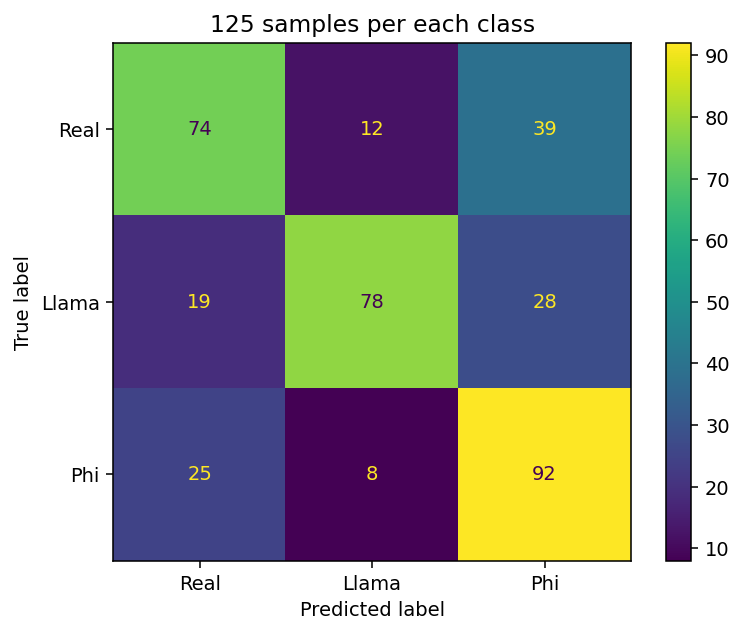

In [17]:
mpl.rcParams['figure.dpi'] = 140

cm = confusion_matrix(true_labels, pred_labels, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Llama', 'Phi'])
disp.plot()

plt.title('125 samples per each class')
plt.show()